In [1]:
import jax
from flax import nnx

In [2]:
# Import additional libraries for data loading and training
from datasets import load_dataset, Dataset
import numpy as np
import optax
from tqdm import tqdm
from typing import Optional, Callable

/home/lukasfri/Repositories/github.com/lukasfri/kth-dd2610-project/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.devices()

W1211 00:01:12.877097  407737 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1211 00:01:12.879176  404409 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


[CudaDevice(id=0)]

In [4]:
data_dir = "./data"
# Load CIFAR-10 dataset
dataset = load_dataset("uoft-cs/cifar10", cache_dir=data_dir)
dataset = dataset.with_format("jax")
train_data = dataset["train"]
test_data = dataset["test"]
assert isinstance(train_data, Dataset)
assert isinstance(test_data, Dataset)

print(train_data.features)

print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Sample shape: {train_data[0]['img'].shape}")

data_dim = train_data[0]["img"].shape[0] * train_data[0]["img"].shape[1] * train_data[0]["img"].shape[2]


{'img': Image(mode=None, decode=True), 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])}
Train samples: 50000
Test samples: 10000
Sample shape: (32, 32, 3)


In [5]:
# Training configuration
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
SAVE_EVERY_N_EPOCHS = 1

In [6]:
from typing import TypedDict
import grain.python as grain
import jax.numpy as jnp


seed = 12
val_batch_size = 2 * BATCH_SIZE


def preprocess(image: jnp.ndarray, *, rng: Optional[np.random.Generator] = None) -> jnp.ndarray:
    # Convert to float32 and normalize to [0, 1]
    image = jnp.array(image, dtype=jnp.float32) / 255.0
    # Flatten the image
    return image
    
assert isinstance(train_data, Dataset)
assert isinstance(test_data, Dataset)

train_grain_dataset = grain.MapDataset.source(train_data) \
    .random_map(lambda x, rng: preprocess(x["img"], rng = rng), seed=42) \
    .shuffle(seed=45) \
    .batch(batch_size=BATCH_SIZE)

test_grain_dataset = grain.MapDataset.source(test_data) \
    .random_map(lambda x, rng: preprocess(x["img"], rng = rng), seed=42) \
    .shuffle(seed=45) \
    .batch(batch_size=val_batch_size)

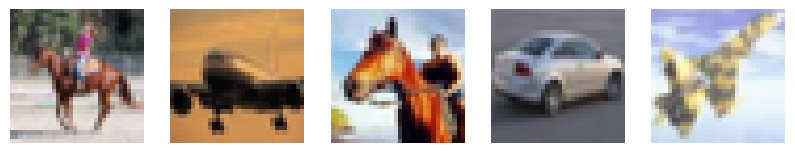

In [7]:
# Display 5 samples from the training dataset
import matplotlib.pyplot as plt

example_batch = next(iter(train_grain_dataset))
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(example_batch[i].reshape(32, 32, 3))
    axes[i].axis('off')
plt.show()

In [8]:
from typing import Literal


def get_norm_layer(norm_type: Literal["BN", "LN", "GN"], num_features: int, rngs: nnx.Rngs) -> Callable[[jax.Array], jax.Array]:
    """Normalization layer."""
    if norm_type == 'BN':
        raise NotImplementedError
    elif norm_type == 'LN':
        norm_fn = nnx.LayerNorm(num_features=num_features, rngs=rngs)
    elif norm_type == 'GN':
        norm_fn = nnx.GroupNorm(num_features=num_features, rngs=rngs)
    else:
        raise NotImplementedError
    return norm_fn


def tensorflow_style_avg_pooling(x: jax.Array, window_shape: tuple[int, int], strides: tuple[int, int], padding: str) -> jax.Array:
    pool_sum = jax.lax.reduce_window(x, 0.0, jax.lax.add,
                                   (1,) + window_shape + (1,),
                                   (1,) + strides + (1,), padding)
    pool_denom = jax.lax.reduce_window(
        jnp.ones_like(x), 0.0, jax.lax.add, (1,) + window_shape + (1,),
        (1,) + strides + (1,), padding)
    return pool_sum / pool_denom

def upsample_2d(x: jax.Array, factor: int = 2) -> jax.Array:
    n, h, w, c = x.shape
    x = jax.image.resize(x, (n, h * factor, w * factor, c), method='nearest')
    return x

def downsample_2d(x: jax.Array) -> jax.Array:
    return tensorflow_style_avg_pooling(x, (2, 2), strides=(2, 2), padding='same')

def squared_euclidean_distance(a: jnp.ndarray,
                               b: jnp.ndarray,
                               b2: Optional[jnp.ndarray] = None) -> jnp.ndarray:
    """Computes the pairwise squared Euclidean distance.

    Args:
        a: float32: (n, d): An array of points.
        b: float32: (m, d): An array of points.
        b2: float32: (d, m): b square transpose.

    Returns:
        d: float32: (n, m): Where d[i, j] is the squared Euclidean distance between
        a[i] and b[j].
    """
    if b2 is None:
        b2 = jnp.sum(b.T**2, axis=0, keepdims=True)
    a2 = jnp.sum(a**2, axis=1, keepdims=True)
    ab = jnp.matmul(a, b.T)
    d = a2 - 2 * ab + b2
    return d

def entropy_loss_fn(affinity: jax.Array, loss_type: Literal["softmax", "argmax"] = "softmax", temperature: float = 1.0):
    """Calculates the entropy loss. Affinity is the similarity/distance matrix."""
    flat_affinity = affinity.reshape(-1, affinity.shape[-1])
    flat_affinity /= temperature
    probs = jax.nn.softmax(flat_affinity, axis=-1)
    log_probs = jax.nn.log_softmax(flat_affinity + 1e-5, axis=-1)
    if loss_type == "softmax":
        target_probs = probs
    elif loss_type == "argmax":
        codes = jnp.argmax(flat_affinity, axis=-1)
        onehots = jax.nn.one_hot(
            codes, flat_affinity.shape[-1], dtype=flat_affinity.dtype)
        onehots = probs - jax.lax.stop_gradient(probs - onehots)
        target_probs = onehots
    else:
        raise ValueError("Entropy loss {} not supported".format(loss_type))
    avg_probs = jnp.mean(target_probs, axis=0)
    avg_entropy = -jnp.sum(avg_probs * jnp.log(avg_probs + 1e-5))
    sample_entropy = -jnp.mean(jnp.sum(target_probs * log_probs, axis=-1))
    loss = sample_entropy - avg_entropy
    return loss

def sg(x: jax.Array) -> jax.Array:
    return jax.lax.stop_gradient(x)


In [9]:
class ResBlock(nnx.Module):
    """Basic Residual Block."""
    norm_1: Callable[[jax.Array], jax.Array]
    activation_fn1: Callable[[jax.Array], jax.Array]
    conv_1: nnx.Conv
    norm_2: Callable[[jax.Array], jax.Array]
    activation_fn2: Callable[[jax.Array], jax.Array]
    conv_2: nnx.Conv
    residual_conv: nnx.Conv
    in_features: int
    out_features: int

    
    def __init__(self, in_features: int, out_features: int, norm_type: Literal['BN', 'LN', 'GN'], activation_fn: Callable[[jax.Array], jax.Array], rngs: nnx.Rngs):
        self.in_features = in_features
        self.out_features = out_features
        self.norm_1 = get_norm_layer(norm_type, in_features, rngs)
        self.activation_fn1 = activation_fn
        self.conv_1 = nnx.Conv(in_features, kernel_size=(3, 3), use_bias=False, out_features=out_features, rngs=rngs)
        self.norm_2 = get_norm_layer(norm_type, out_features, rngs)
        self.activation_fn2 = activation_fn
        self.conv_2 = nnx.Conv(out_features, kernel_size=(3, 3), use_bias=False, out_features=out_features, rngs=rngs)
        self.residual_conv = nnx.Conv(in_features, kernel_size=(1, 1), use_bias=False, out_features=out_features, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        input_dim = x.shape[-1]
        residual = x
        x= self.norm_1(x)
        x= self.activation_fn1(x)
        x= self.conv_1(x)
        x= self.norm_2(x)
        x= self.activation_fn2(x)
        x= self.conv_2(x)

        if input_dim != x.shape[-1]:
            residual = self.residual_conv(residual)
        
        return x + residual
    
def multi_resblock(num_blocks: int, in_features: int, out_features: int, norm_type: Literal['BN', 'LN', 'GN'], activation_fn: Callable[[jax.Array], jax.Array], rngs: nnx.Rngs) -> nnx.Sequential:
    return nnx.Sequential(*[
        ResBlock(
            in_features=in_features if i == 0 else out_features,
            out_features=out_features,
            norm_type=norm_type,
            activation_fn=activation_fn,
            rngs=rngs)
        for i in range(num_blocks)
    ])

class Encoder(nnx.Module):
    """From [H,W,D] image to [H',W',D'] embedding. Using Conv layers."""

    norm_layer: Callable[[jax.Array], jax.Array]
    initial_conv: nnx.Conv
    activation_fn: Callable[[jax.Array], jax.Array]
    blocks: nnx.Sequential
    final_res_blocks: nnx.Sequential
    last_conv: nnx.Conv

    def __init__(self, filters: int, num_res_blocks: int, channel_multipliers: list[int], embedding_dim: int, norm_type: Literal['BN', 'LN', 'GN'], quantizer_type: str, image_channels: int, rngs: nnx.Rngs, activation_fn: Callable[[jax.Array], jax.Array] = nnx.swish):
        self.norm_layer = get_norm_layer(norm_type, filters * channel_multipliers[-1], rngs)
        self.activation_fn = activation_fn

        self.initial_conv = nnx.Conv(kernel_size=(3, 3), use_bias=False, in_features=image_channels, out_features=filters, rngs=rngs)

        self.blocks = nnx.Sequential(*[
            nnx.Sequential(
                multi_resblock(
                    num_blocks=num_res_blocks,
                    in_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                    out_features=filters * channel_multipliers[i],
                    norm_type=norm_type,
                    activation_fn=activation_fn,
                    rngs=rngs),
                # Add downsample layer if not the last block
                *([] if i == len(channel_multipliers) - 1 else [lambda x: downsample_2d(x)])
            )
            for i in range(len(channel_multipliers))
        ])

        # Then add the final res blocks
        self.final_res_blocks = multi_resblock(
            num_blocks=num_res_blocks,
                in_features=filters * channel_multipliers[-1],
                out_features=filters * channel_multipliers[-1],
                norm_type=norm_type,
                activation_fn=activation_fn,
                rngs=rngs)
        
        last_dim = embedding_dim*2 if quantizer_type == 'kl' else embedding_dim
        self.last_conv = nnx.Conv(
            in_features=filters * channel_multipliers[-1],
            out_features=last_dim,
            kernel_size=(1, 1),
            use_bias=False,
            rngs=rngs)
        

    def __call__(self, x):
        x = self.initial_conv(x)
        x = self.blocks(x)

        x = self.final_res_blocks(x)
        x = self.norm_layer(x)
        x = self.activation_fn(x)

        x = self.last_conv(x)

        return x
    
class Decoder(nnx.Module):
    """From [H',W',D'] embedding to [H,W,D] embedding. Using Conv layers."""

    def __init__(self, embedding_dim: int, filters: int, num_res_blocks: int, channel_multipliers: list[int], image_channels: int, norm_type: Literal['BN', 'LN', 'GN'], rngs: nnx.Rngs, activation_fn: Callable[[jax.Array], jax.Array] = nnx.swish):
        self.norm_layer = get_norm_layer(norm_type, filters, rngs)
        self.activation_fn = activation_fn
        self.initial_conv = nnx.Conv(in_features=embedding_dim, kernel_size=(3, 3), use_bias=True, out_features=filters * channel_multipliers[-1], rngs=rngs)


        self.initial_res_blocks = multi_resblock(
            num_blocks=num_res_blocks,
                in_features=filters * channel_multipliers[-1],
                out_features=filters * channel_multipliers[-1],
                norm_type=norm_type,
                activation_fn=activation_fn,
                rngs=rngs)

        # Decoder blocks with upsampling
        self.decoder_blocks = nnx.Sequential(*[
            nnx.Sequential(
                multi_resblock(
                    num_blocks=num_res_blocks,
                    in_features=filters * channel_multipliers[i],
                    out_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                    norm_type=norm_type,
                    activation_fn=activation_fn,
                    rngs=rngs)
                ,
                # Add upsample_2d + conv if not the first block (i > 0)
                *([] if i == 0 else [
                    lambda x: upsample_2d(x, 2),
                    nnx.Conv(
                        in_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                        out_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                        kernel_size=(3, 3),
                        rngs=rngs)
                ])
            )
            for i in reversed(range(len(channel_multipliers)))
        ])
        self.final_conv = nnx.Conv(in_features=filters, out_features=image_channels, kernel_size=(3, 3), rngs=rngs)

    def __call__(self, x):
        x = self.initial_conv(x)
        x = self.initial_res_blocks(x)
        x = self.decoder_blocks(x)
        x = self.norm_layer(x)
        x = self.activation_fn(x)
        x = self.final_conv(x)
        
        return x

In [10]:
from typing import Literal
from flax import nnx
import jax.numpy as jnp
import jax
 
class VectorQuantizerCodebook(nnx.Param[jax.Array]): pass

class VectorQuantizer(nnx.Module):
    """Basic vector quantizer."""
    deterministic: bool = False
    codebook: VectorQuantizerCodebook
    commitment_cost: float
    entropy_loss_type: Literal["softmax", "argmax"]
    entropy_loss_ratio: float
    entropy_temperature: float

    def __init__(self, codebook_size: int, embedding_dim: int, commitment_cost: float, entropy_loss_type: Literal['softmax', 'argmax'], entropy_loss_ratio: float, entropy_temperature: float, rngs: nnx.Rngs):
        codebook_initializer = nnx.initializers.variance_scaling(scale=1.0, mode="fan_in", distribution="uniform")
        self.codebook = VectorQuantizerCodebook(
            codebook_initializer(rngs.params(), shape =(codebook_size, embedding_dim))
        )
        self.commitment_cost = commitment_cost
        self.entropy_loss_type = entropy_loss_type
        self.entropy_loss_ratio = entropy_loss_ratio
        self.entropy_temperature = entropy_temperature

    def __call__(self, x: jax.Array) -> tuple[jax.Array, dict[str, jax.Array]]:
        S, L = self.codebook.shape # S: codebook_size, L: embedding_dim

        distances = jnp.reshape(
            squared_euclidean_distance(jnp.reshape(x, (-1, L)), self.codebook),
            x.shape[:-1] + (S,)) # [x, codebook_size] similarity matrix.
        encoding_indices = jnp.argmin(distances, axis=-1)
        encoding_onehot = jax.nn.one_hot(encoding_indices, S)
        quantized = self.quantize(encoding_onehot)
        result_dict: dict[str, jax.Array] = dict()
        if not self.deterministic:
            e_latent_loss = jnp.mean((sg(quantized) - x)**2) * self.commitment_cost
            q_latent_loss = jnp.mean((quantized - sg(x))**2)
            entropy_loss = 0.0
            if self.entropy_loss_ratio != 0:
                entropy_loss = entropy_loss_fn(
                    -distances,
                    loss_type=self.entropy_loss_type,
                    temperature=self.entropy_temperature
                ) * self.entropy_loss_ratio
            e_latent_loss = jnp.asarray(e_latent_loss, jnp.float32)
            q_latent_loss = jnp.asarray(q_latent_loss, jnp.float32)
            entropy_loss = jnp.asarray(entropy_loss, jnp.float32)
            loss = e_latent_loss + q_latent_loss + entropy_loss
            result_dict = dict(
                quantizer_loss=loss,
                e_latent_loss=e_latent_loss,
                q_latent_loss=q_latent_loss,
                entropy_loss=entropy_loss)
            quantized = x + jax.lax.stop_gradient(quantized - x)

        result_dict.update({
            "z_ids": encoding_indices,
        })
        return quantized, result_dict

    def quantize(self, encoding_onehot: jnp.ndarray) -> jnp.ndarray:
        return jnp.dot(encoding_onehot, self.codebook[...])

    def decode_ids(self, ids: jnp.ndarray) -> jnp.ndarray:
        return jnp.take(self.codebook[...], ids, axis=0)

In [11]:
### FSQ stuff
class FiniteScalarQuantizer(nnx.Module):
    latent_dim: int
    L: jax.Array
    debug: bool

    def __init__(self, L: list[int], debug=False):
        """
        L : iterable of ints, length D
        """
        self.latent_dim = len(L)
        self.L = jnp.array(L, dtype=jnp.float32)  # convert to array
        self.debug = debug

        if self.debug:
            print(f"Latent channels: {self.latent_dim}")
            print(f"Quant levels: {self.L}")
            print(f"Mapping range: {-jnp.floor(self.L / 2)} to {jnp.floor(self.L / 2)}")

    def q_func(self, x: jax.Array) -> jax.Array:
        """
        x: [B*H*W, D]
        self.L: [D]
        Returns quantized but not rounded values
        """
        # Expand L to broadcast along batch dimension
        L_broadcast = self.L[None, :]   # shape [1, D], broadcasts to [B*H*W, D]
        return jnp.tanh(x) * jnp.floor(L_broadcast / 2)

    def __call__(self, z: jax.Array) -> jax.Array:
        """
        z : [B, H, W, D]
        returns quantized z_q : [B, H, W, D]
        """
        B, H, W, D = z.shape
        assert D == self.latent_dim, "latent_dim mismatch"

        # Flatten spatial dims
        z_flat = z.reshape((B * H * W, D))

        # Quantize
        z_q_flat = jnp.round(self.q_func(z_flat))

        # Restore shape
        z_q = z_q_flat.reshape((B, H, W, D))
        return z_q

In [25]:
from typing import Any

class Config(TypedDict):
    id: str
    codebook_size: Optional[int]
    codebook_shape: Optional[list[int]]
    embedding_dim: Optional[int]
    commitment_cost: float
    entropy_loss_type: Literal["softmax", "argmax"]
    entropy_loss_ratio: float
    entropy_temperature: float
    filters: int
    num_res_blocks: int
    channel_multipliers: list[int]
    norm_type: Literal['BN', 'LN', 'GN']
    quantizer_type: Literal['fsq', 'standard', 'kl']
    image_channels: int


class VQVAE(nnx.Module):
    """VQVAE model."""
    quantizer: Callable[[jax.Array], tuple[jax.Array, Any] | jax.Array]
    encoder: Encoder
    decoder: Decoder
    rngs: nnx.Rngs

    def __init__(self, config: Config, rngs: nnx.Rngs):
        """VQVAE setup."""
        embedding_dim = config['embedding_dim']
        if embedding_dim is None and config['codebook_shape'] is not None:
            embedding_dim = len(config['codebook_shape'])
        
        if embedding_dim is None:
            raise ValueError("embedding_dim must be specified in config if codebook_shape is not provided.")

        match config['quantizer_type']:
            case 'fsq':
                if config['codebook_shape'] is None:
                    raise ValueError("codebook_shape must be specified for fsq quantizer.")
                self.quantizer = FiniteScalarQuantizer(
                    L = config['codebook_shape']
                )
            case 'standard':
                if config['codebook_size'] is None or config['embedding_dim'] is None:
                    raise ValueError("codebook_size and embedding_dim must be specified for standard quantizer.")
                self.quantizer = VectorQuantizer(
                    codebook_size = config['codebook_size'],
                    embedding_dim = config['embedding_dim'],
                    commitment_cost = config['commitment_cost'],
                    entropy_loss_type = config['entropy_loss_type'],
                    entropy_loss_ratio = config['entropy_loss_ratio'],
                    entropy_temperature = config['entropy_temperature'],
                    rngs = rngs)
            case _:
                raise ValueError(f"Unknown quantizer type: {config['quantizer_type']}")
            
        self.encoder = Encoder(
            filters = config['filters'],
            num_res_blocks =config['num_res_blocks'],
            channel_multipliers = config['channel_multipliers'],
            embedding_dim = embedding_dim,
            norm_type=config['norm_type'],
            quantizer_type = config['quantizer_type'],
            image_channels = config['image_channels'],
            rngs = rngs
        )
        self.decoder = Decoder(
            embedding_dim = embedding_dim,
            filters = config['filters'],
            num_res_blocks = config['num_res_blocks'],
            channel_multipliers = config['channel_multipliers'],
            image_channels = config['image_channels'],
            norm_type=config['norm_type'],
            rngs = rngs
        )
        self.rngs = rngs

    def encode(self, image: jax.Array) -> tuple[jax.Array, dict[str, jax.Array]]:
        encoded_feature = self.encoder(image)
        if isinstance(self.quantizer, FiniteScalarQuantizer):
            quantized = self.quantizer(encoded_feature)
            result_dict: dict[str, jax.Array] = {}
        else:
            quantized, result_dict = self.quantizer(encoded_feature)
        return quantized, result_dict

    def decode(self, z_vectors: jax.Array) -> jax.Array:
        reconstructed = self.decoder(z_vectors)
        return reconstructed

    def decode_from_indices(self, z_ids: jax.Array) -> jax.Array:
        z_vectors = self.quantizer.decode_ids(z_ids)
        reconstructed_image = self.decode(z_vectors)
        return reconstructed_image

    def encode_to_indices(self, image: jax.Array) -> jax.Array:
        encoded_feature = self.encoder(image)
        _, result_dict = self.quantizer(encoded_feature)
        ids = result_dict["z_ids"]
        return ids

    def __call__(self, input_dict: jax.Array) -> tuple[jax.Array, dict[str, jax.Array]]:
        quantized, result_dict = self.encode(input_dict)
        outputs = self.decoder(quantized)
        return outputs, result_dict

In [13]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "val_loss": [],
    "val_accuracy": [],
}

In [21]:
# Define loss function

def mse(x1: jax.Array, x2: jax.Array) -> jax.Array:
    return jnp.mean((x1 - x2) ** 2)

def mse_loss(model: VQVAE, x: jax.Array) -> jax.Array:
    """Mean squared error reconstruction loss"""
    x_reconstructed, _ = model(x)
    return mse(x, x_reconstructed)

def total_loss(model: VQVAE, x: jax.Array) -> jax.Array:
    """Total loss including reconstruction and quantizer losses"""
    x_reconstructed, result_dict = model(x)
    recon_loss = mse(x, x_reconstructed)
    quantizer_loss = result_dict["quantizer_loss"]
    return recon_loss + quantizer_loss

def entropy_loss(model: VQVAE, x: jax.Array) -> jax.Array:
    """Entropy loss from the quantizer"""
    _, result_dict = model(x)
    return result_dict["entropy_loss"]

@nnx.jit(static_argnames=['loss_fn'])
def train_step(model: VQVAE, optimizer: nnx.Optimizer[VQVAE], x: jax.Array, loss_fn: Callable[[VQVAE, jax.Array], jax.Array]) -> jax.Array:
    """Single training step"""
    loss, grads = nnx.value_and_grad(loss_fn)(model, x)
    
    # Update with BOTH model and grads
    optimizer.update(grads=grads, model=model) 
    return loss

In [15]:
import orbax.checkpoint as ocp
from orbax.checkpoint.checkpoint_managers import preservation_policy as ocp_pp

model_dir = '/home/lukasfri/Repositories/github.com/lukasfri/kth-dd2610-project/src/models'

def create_ocp_manager(model_dir: str, config: Config) -> ocp.CheckpointManager:
    options = ocp.CheckpointManagerOptions(
        preservation_policy=ocp_pp.AnyPreservationPolicy([
            ocp_pp.LatestN(2),
            ocp_pp.EveryNSteps(10),
        ]),
         create=True)
    manager = ocp.CheckpointManager(f'{model_dir}/named/{config["id"]}', options=options)
    return manager

def load_model_checkpoint(model_dir: str, config: Config) -> Optional[tuple[VQVAE, int]]:
    with create_ocp_manager(model_dir, config) as manager:
        abstract_model = nnx.eval_shape(lambda: VQVAE(config=config, rngs=nnx.Rngs(0)))

        graphdef, abstract_state = nnx.split(abstract_model)

        step_to_restore = manager.latest_step()
        if step_to_restore is not None:
            restored_state = manager.restore(step_to_restore, args=ocp.args.StandardRestore(abstract_state))
            start_step = step_to_restore + 1
            return nnx.merge(graphdef, restored_state), start_step
        else:
            return None

def load_model_checkpoint_or_initialize(model_dir: str, config: Config) -> tuple[VQVAE, int]:
    restored = load_model_checkpoint(model_dir, config)
    if restored is not None:
        model, start_step = restored
        print(f"Restored model from step {start_step}.")
        return model, start_step
    else:
        model = VQVAE(config=config, rngs=nnx.Rngs(0))
        print("Initialized new model.")
        return model, 0

In [ ]:
def train_cycle(model: VQVAE, config: Config, max_epochs: int, start_epoch: int, loss_fn: Callable[[VQVAE, jax.Array], jax.Array]):
    manager = create_ocp_manager(model_dir, config)

    total_steps = len(train_data) // BATCH_SIZE
    BAR_FORMAT = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"

    optimizer = nnx.Optimizer(model, optax.adam(LEARNING_RATE), wrt=nnx.Param)

    model.train()
    # Training loop
    for epoch in range(start_epoch, max_epochs):
        epoch_losses = []
        
        # Create progress bar
        with tqdm(
            desc=f"[train] epoch: {epoch+1}/{max_epochs}, ",
            total=total_steps,
            bar_format=BAR_FORMAT,
            leave=True,
        ) as pbar:
            for batch in train_grain_dataset:
                loss = train_step(model, optimizer, batch, loss_fn)
                loss = float(loss.item())
                train_metrics_history["train_loss"].append(loss)
                pbar.set_postfix({"loss": loss})
                pbar.update(1)
            
        
        avg_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1}/{max_epochs} - Average Loss: {avg_loss:.4f}")

        if (epoch + 1) % SAVE_EVERY_N_EPOCHS == 0:
            state = nnx.state(model)
            manager.save(epoch, args=ocp.args.StandardSave(state))
            manager.wait_until_finished()

            print(f"Checkpoint saved for epoch {epoch}.")
    manager.close()

In [ ]:

def eval_model(model: VQVAE, loss_fn: Callable[[VQVAE, jax.Array], jax.Array]):
    model.eval()

    # Evaluate on test set
    test_losses = []

    BAR_FORMAT = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"

    with tqdm(
        desc=f"[test] ",
        total=len(test_data) // val_batch_size,
        bar_format=BAR_FORMAT,
        leave=True,
    ) as pbar:
        for batch_x in test_grain_dataset:
            loss = loss_fn(model, batch_x)
            loss = float(loss.item())
            test_losses.append(loss)
            pbar.set_postfix({"loss": loss})
            pbar.update(1)

    avg_test_loss = np.mean(test_losses)
    print(f"Test Loss: {avg_test_loss:.4f}")

In [22]:
# VQVAE Training
vqvae_config = Config({
    "id": "vqvae_new",
    "codebook_size": 512,
    "embedding_dim": 64,
    "codebook_shape": None,
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.0,
    "entropy_temperature": 1.0,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "LN",
    "quantizer_type": "standard",
    "image_channels": 3,
})

vqvae, start_step = load_model_checkpoint_or_initialize(model_dir, vqvae_config)

train_cycle(vqvae, vqvae_config, NUM_EPOCHS, start_step, loss_fn=total_loss)

Initialized new model.


[train] epoch: 1/100, [0/390] [00:00<?]E1211 00:09:50.722558  407782 slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce_window_sum.43 = f32[128,16,16,128]{3,2,1,0} reduce-window(%broadcast_in_dim.100, %constant.391), window={size=1x2x2x1 stride=1x2x2x1}, to_apply=%region_9.11, metadata={op_name="jit(train_step)/jvp()/reduce_window_sum" source_file="/tmp/ipykernel_404409/724243961.py" source_line=21 source_end_line=23 source_column=17 source_end_column=39}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
E1211 00:09:50.989216  404409 slow_operation_alarm.cc:140] The operation took 1.267211736s
Constant fol

KeyboardInterrupt: 

In [20]:
eval_model(vqvae, loss_fn=mse_loss)

[test] [40/?], loss=0.0788 [00:14<00:00] 

Test Loss: 0.0623


In [ ]:
# FSQ-VAE Training
fsqvae_config = Config({
    "id": "fsqvae",
    "codebook_size": None,
    "embedding_dim": None,
    "codebook_shape": [8, 8, 8],
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.0,
    "entropy_temperature": 1.0,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "LN",
    "quantizer_type": "fsq",
    "image_channels": 3,
})

fsqvae, start_step = load_model_checkpoint_or_initialize(model_dir, fsqvae_config)

# train_cycle(fsqvae, fsqvae_config, NUM_EPOCHS, start_step, loss_fn=mse_loss)

Initialized new model.


[train] epoch: 1/100, [391/?], loss=0.0617 [01:10<00:00]  


Epoch 1/100 - Average Loss: nan
Checkpoint saved for epoch 0.


[train] epoch: 2/100, [391/?], loss=0.0279 [01:01<00:00]  


Epoch 2/100 - Average Loss: nan
Checkpoint saved for epoch 1.


[train] epoch: 3/100, [391/?], loss=0.0202 [01:01<00:00]  


Epoch 3/100 - Average Loss: nan
Checkpoint saved for epoch 2.


[train] epoch: 4/100, [391/?], loss=0.0184 [01:02<00:00]  


Epoch 4/100 - Average Loss: nan
Checkpoint saved for epoch 3.


[train] epoch: 5/100, [391/?], loss=0.0172 [01:01<00:00]  


Epoch 5/100 - Average Loss: nan
Checkpoint saved for epoch 4.


[train] epoch: 6/100, [391/?], loss=0.0165 [01:01<00:00]  


Epoch 6/100 - Average Loss: nan
Checkpoint saved for epoch 5.


[train] epoch: 7/100, [391/?], loss=0.0154 [01:01<00:00]  


Epoch 7/100 - Average Loss: nan
Checkpoint saved for epoch 6.


[train] epoch: 8/100, [391/?], loss=0.0149 [01:02<00:00]  


Epoch 8/100 - Average Loss: nan
Checkpoint saved for epoch 7.


[train] epoch: 9/100, [391/?], loss=0.0148 [01:01<00:00]  


Epoch 9/100 - Average Loss: nan
Checkpoint saved for epoch 8.


[train] epoch: 10/100, [391/?], loss=0.0145 [01:01<00:00]  


Epoch 10/100 - Average Loss: nan
Checkpoint saved for epoch 9.


[train] epoch: 11/100, [391/?], loss=0.0138 [01:01<00:00]  


Epoch 11/100 - Average Loss: nan
Checkpoint saved for epoch 10.


[train] epoch: 12/100, [391/?], loss=0.0134 [01:01<00:00]  


Epoch 12/100 - Average Loss: nan
Checkpoint saved for epoch 11.


[train] epoch: 13/100, [391/?], loss=0.0132 [01:01<00:00]  


Epoch 13/100 - Average Loss: nan
Checkpoint saved for epoch 12.


[train] epoch: 14/100, [391/?], loss=0.013 [01:01<00:00]   


Epoch 14/100 - Average Loss: nan
Checkpoint saved for epoch 13.


[train] epoch: 15/100, [391/?], loss=0.0129 [01:01<00:00]  


Epoch 15/100 - Average Loss: nan
Checkpoint saved for epoch 14.


[train] epoch: 16/100, [391/?], loss=0.0129 [01:01<00:00]  


Epoch 16/100 - Average Loss: nan
Checkpoint saved for epoch 15.


[train] epoch: 17/100, [391/?], loss=0.0127 [01:01<00:00]  


Epoch 17/100 - Average Loss: nan
Checkpoint saved for epoch 16.


[train] epoch: 18/100, [391/?], loss=0.0128 [01:01<00:00]  


Epoch 18/100 - Average Loss: nan
Checkpoint saved for epoch 17.


[train] epoch: 19/100, [391/?], loss=0.0122 [01:01<00:00]  


Epoch 19/100 - Average Loss: nan
Checkpoint saved for epoch 18.


[train] epoch: 20/100, [391/?], loss=0.012 [01:01<00:00]   


Epoch 20/100 - Average Loss: nan
Checkpoint saved for epoch 19.


[train] epoch: 21/100, [391/?], loss=0.0113 [01:01<00:00]  


Epoch 21/100 - Average Loss: nan
Checkpoint saved for epoch 20.


[train] epoch: 22/100, [391/?], loss=0.011 [01:01<00:00]   


Epoch 22/100 - Average Loss: nan
Checkpoint saved for epoch 21.


[train] epoch: 23/100, [391/?], loss=0.0107 [01:02<00:00]  


Epoch 23/100 - Average Loss: nan
Checkpoint saved for epoch 22.


[train] epoch: 24/100, [391/?], loss=0.0112 [01:01<00:00]   


Epoch 24/100 - Average Loss: nan
Checkpoint saved for epoch 23.


[train] epoch: 25/100, [391/?], loss=0.0108 [01:01<00:00]   


Epoch 25/100 - Average Loss: nan
Checkpoint saved for epoch 24.


[train] epoch: 26/100, [391/?], loss=0.0105 [01:01<00:00]   


Epoch 26/100 - Average Loss: nan
Checkpoint saved for epoch 25.


[train] epoch: 27/100, [391/?], loss=0.00993 [01:02<00:00]  


Epoch 27/100 - Average Loss: nan
Checkpoint saved for epoch 26.


[train] epoch: 28/100, [391/?], loss=0.00957 [01:01<00:00]  


Epoch 28/100 - Average Loss: nan
Checkpoint saved for epoch 27.


[train] epoch: 29/100, [391/?], loss=0.00938 [01:01<00:00]  


Epoch 29/100 - Average Loss: nan
Checkpoint saved for epoch 28.


[train] epoch: 30/100, [391/?], loss=0.00912 [01:01<00:00]  


Epoch 30/100 - Average Loss: nan
Checkpoint saved for epoch 29.


[train] epoch: 31/100, [391/?], loss=0.00855 [01:01<00:00]  


Epoch 31/100 - Average Loss: nan
Checkpoint saved for epoch 30.


[train] epoch: 32/100, [391/?], loss=0.00853 [01:01<00:00]  


Epoch 32/100 - Average Loss: nan
Checkpoint saved for epoch 31.


[train] epoch: 33/100, [391/?], loss=0.00822 [01:01<00:00]  


Epoch 33/100 - Average Loss: nan
Checkpoint saved for epoch 32.


[train] epoch: 34/100, [391/?], loss=0.00799 [01:01<00:00]  


Epoch 34/100 - Average Loss: nan
Checkpoint saved for epoch 33.


[train] epoch: 35/100, [391/?], loss=0.00797 [01:01<00:00]  


Epoch 35/100 - Average Loss: nan
Checkpoint saved for epoch 34.


[train] epoch: 36/100, [391/?], loss=0.00773 [01:01<00:00]  


Epoch 36/100 - Average Loss: nan
Checkpoint saved for epoch 35.


[train] epoch: 37/100, [391/?], loss=0.00784 [01:01<00:00]  


Epoch 37/100 - Average Loss: nan
Checkpoint saved for epoch 36.


[train] epoch: 38/100, [391/?], loss=0.00762 [01:01<00:00]  


Epoch 38/100 - Average Loss: nan
Checkpoint saved for epoch 37.


[train] epoch: 39/100, [391/?], loss=0.00757 [01:01<00:00]  


Epoch 39/100 - Average Loss: nan
Checkpoint saved for epoch 38.


[train] epoch: 40/100, [391/?], loss=0.00687 [01:01<00:00]  


Epoch 40/100 - Average Loss: nan
Checkpoint saved for epoch 39.


[train] epoch: 41/100, [391/?], loss=0.00715 [01:02<00:00]  


Epoch 41/100 - Average Loss: nan
Checkpoint saved for epoch 40.


[train] epoch: 42/100, [391/?], loss=0.00665 [01:02<00:00]  


Epoch 42/100 - Average Loss: nan
Checkpoint saved for epoch 41.


[train] epoch: 43/100, [391/?], loss=0.00728 [01:01<00:00]  


Epoch 43/100 - Average Loss: nan
Checkpoint saved for epoch 42.


[train] epoch: 44/100, [391/?], loss=0.00663 [01:01<00:00]  


Epoch 44/100 - Average Loss: nan
Checkpoint saved for epoch 43.


[train] epoch: 45/100, [391/?], loss=0.00626 [01:01<00:00]  


Epoch 45/100 - Average Loss: nan
Checkpoint saved for epoch 44.


[train] epoch: 46/100, [391/?], loss=0.00639 [01:02<00:00]  


Epoch 46/100 - Average Loss: nan
Checkpoint saved for epoch 45.


[train] epoch: 47/100, [391/?], loss=0.00607 [01:01<00:00]  


Epoch 47/100 - Average Loss: nan
Checkpoint saved for epoch 46.


[train] epoch: 48/100, [391/?], loss=0.00634 [01:01<00:00]  


Epoch 48/100 - Average Loss: nan
Checkpoint saved for epoch 47.


[train] epoch: 49/100, [391/?], loss=0.00576 [01:01<00:00]  


Epoch 49/100 - Average Loss: nan
Checkpoint saved for epoch 48.


[train] epoch: 50/100, [391/?], loss=0.00575 [01:02<00:00]  


Epoch 50/100 - Average Loss: nan
Checkpoint saved for epoch 49.


[train] epoch: 51/100, [391/?], loss=0.00548 [01:01<00:00]  


Epoch 51/100 - Average Loss: nan
Checkpoint saved for epoch 50.


[train] epoch: 52/100, [391/?], loss=0.00533 [01:01<00:00]  


Epoch 52/100 - Average Loss: nan
Checkpoint saved for epoch 51.


[train] epoch: 53/100, [391/?], loss=0.0053 [01:01<00:00]   


Epoch 53/100 - Average Loss: nan
Checkpoint saved for epoch 52.


[train] epoch: 54/100, [391/?], loss=0.00607 [01:01<00:00]  


Epoch 54/100 - Average Loss: nan
Checkpoint saved for epoch 53.


[train] epoch: 55/100, [391/?], loss=0.00538 [01:01<00:00]  


Epoch 55/100 - Average Loss: nan
Checkpoint saved for epoch 54.


[train] epoch: 56/100, [391/?], loss=0.00575 [01:01<00:00]  


Epoch 56/100 - Average Loss: nan
Checkpoint saved for epoch 55.


[train] epoch: 57/100, [391/?], loss=0.00525 [01:01<00:00]  


Epoch 57/100 - Average Loss: nan
Checkpoint saved for epoch 56.


[train] epoch: 58/100, [391/?], loss=0.00508 [01:01<00:00]  


Epoch 58/100 - Average Loss: nan
Checkpoint saved for epoch 57.


[train] epoch: 59/100, [391/?], loss=0.00501 [01:01<00:00]  


Epoch 59/100 - Average Loss: nan
Checkpoint saved for epoch 58.


[train] epoch: 60/100, [391/?], loss=0.00494 [01:01<00:00]  


Epoch 60/100 - Average Loss: nan
Checkpoint saved for epoch 59.


[train] epoch: 61/100, [391/?], loss=0.00501 [01:01<00:00]  


Epoch 61/100 - Average Loss: nan
Checkpoint saved for epoch 60.


[train] epoch: 62/100, [391/?], loss=0.00467 [01:01<00:00]  


Epoch 62/100 - Average Loss: nan
Checkpoint saved for epoch 61.


[train] epoch: 63/100, [391/?], loss=0.00469 [01:01<00:00]  


Epoch 63/100 - Average Loss: nan
Checkpoint saved for epoch 62.


[train] epoch: 64/100, [391/?], loss=0.00451 [01:01<00:00]  


Epoch 64/100 - Average Loss: nan
Checkpoint saved for epoch 63.


[train] epoch: 65/100, [391/?], loss=0.00455 [01:02<00:00]  


Epoch 65/100 - Average Loss: nan
Checkpoint saved for epoch 64.


[train] epoch: 66/100, [391/?], loss=0.00432 [01:01<00:00]  


Epoch 66/100 - Average Loss: nan
Checkpoint saved for epoch 65.


[train] epoch: 67/100, [391/?], loss=0.00431 [01:01<00:00]  


Epoch 67/100 - Average Loss: nan
Checkpoint saved for epoch 66.


[train] epoch: 68/100, [391/?], loss=0.00447 [01:02<00:00]  


Epoch 68/100 - Average Loss: nan
Checkpoint saved for epoch 67.


[train] epoch: 69/100, [391/?], loss=0.00492 [01:01<00:00]  


Epoch 69/100 - Average Loss: nan
Checkpoint saved for epoch 68.


[train] epoch: 70/100, [391/?], loss=0.00445 [01:02<00:00]  


Epoch 70/100 - Average Loss: nan
Checkpoint saved for epoch 69.


[train] epoch: 71/100, [391/?], loss=0.00442 [01:01<00:00]  


Epoch 71/100 - Average Loss: nan
Checkpoint saved for epoch 70.


[train] epoch: 72/100, [391/?], loss=0.004 [01:01<00:00]    


Epoch 72/100 - Average Loss: nan
Checkpoint saved for epoch 71.


[train] epoch: 73/100, [391/?], loss=0.00397 [01:02<00:00]  


Epoch 73/100 - Average Loss: nan
Checkpoint saved for epoch 72.


[train] epoch: 74/100, [391/?], loss=0.00403 [01:01<00:00]  


Epoch 74/100 - Average Loss: nan
Checkpoint saved for epoch 73.


[train] epoch: 75/100, [391/?], loss=0.004 [01:01<00:00]    


Epoch 75/100 - Average Loss: nan
Checkpoint saved for epoch 74.


[train] epoch: 76/100, [391/?], loss=0.00397 [01:01<00:00]  


Epoch 76/100 - Average Loss: nan
Checkpoint saved for epoch 75.


[train] epoch: 77/100, [391/?], loss=0.00414 [01:02<00:00]  


Epoch 77/100 - Average Loss: nan
Checkpoint saved for epoch 76.


[train] epoch: 78/100, [391/?], loss=0.00395 [01:02<00:00]  


Epoch 78/100 - Average Loss: nan
Checkpoint saved for epoch 77.


[train] epoch: 79/100, [391/?], loss=0.00381 [01:01<00:00]  


Epoch 79/100 - Average Loss: nan
Checkpoint saved for epoch 78.


[train] epoch: 80/100, [391/?], loss=0.00359 [01:01<00:00]  


Epoch 80/100 - Average Loss: nan
Checkpoint saved for epoch 79.


[train] epoch: 81/100, [391/?], loss=0.00366 [01:01<00:00]  


Epoch 81/100 - Average Loss: nan
Checkpoint saved for epoch 80.


[train] epoch: 82/100, [391/?], loss=0.0038 [01:01<00:00]   


Epoch 82/100 - Average Loss: nan
Checkpoint saved for epoch 81.


[train] epoch: 83/100, [391/?], loss=0.00369 [01:01<00:00]  


Epoch 83/100 - Average Loss: nan
Checkpoint saved for epoch 82.


[train] epoch: 84/100, [391/?], loss=0.00371 [01:02<00:00]  


Epoch 84/100 - Average Loss: nan
Checkpoint saved for epoch 83.


[train] epoch: 85/100, [391/?], loss=0.00386 [01:01<00:00]  


Epoch 85/100 - Average Loss: nan
Checkpoint saved for epoch 84.


[train] epoch: 86/100, [391/?], loss=0.00379 [01:01<00:00]  


Epoch 86/100 - Average Loss: nan
Checkpoint saved for epoch 85.


[train] epoch: 87/100, [391/?], loss=0.00349 [01:01<00:00]  


Epoch 87/100 - Average Loss: nan
Checkpoint saved for epoch 86.


[train] epoch: 88/100, [391/?], loss=0.00331 [01:01<00:00]  


Epoch 88/100 - Average Loss: nan
Checkpoint saved for epoch 87.


[train] epoch: 89/100, [391/?], loss=0.00346 [01:02<00:00]  


Epoch 89/100 - Average Loss: nan
Checkpoint saved for epoch 88.


[train] epoch: 90/100, [391/?], loss=0.00364 [01:01<00:00]  


Epoch 90/100 - Average Loss: nan
Checkpoint saved for epoch 89.


[train] epoch: 91/100, [391/?], loss=0.00389 [01:01<00:00]  


Epoch 91/100 - Average Loss: nan
Checkpoint saved for epoch 90.


[train] epoch: 92/100, [391/?], loss=0.0035 [01:02<00:00]   


Epoch 92/100 - Average Loss: nan
Checkpoint saved for epoch 91.


[train] epoch: 93/100, [391/?], loss=0.00344 [01:01<00:00]  


Epoch 93/100 - Average Loss: nan
Checkpoint saved for epoch 92.


[train] epoch: 94/100, [391/?], loss=0.00359 [01:01<00:00]  


Epoch 94/100 - Average Loss: nan
Checkpoint saved for epoch 93.


[train] epoch: 95/100, [391/?], loss=0.00345 [01:01<00:00]  


Epoch 95/100 - Average Loss: nan
Checkpoint saved for epoch 94.


[train] epoch: 96/100, [391/?], loss=0.00349 [01:01<00:00]  


Epoch 96/100 - Average Loss: nan
Checkpoint saved for epoch 95.


[train] epoch: 97/100, [391/?], loss=0.0033 [01:01<00:00]   


Epoch 97/100 - Average Loss: nan
Checkpoint saved for epoch 96.


[train] epoch: 98/100, [391/?], loss=0.00305 [01:01<00:00]  


Epoch 98/100 - Average Loss: nan
Checkpoint saved for epoch 97.


[train] epoch: 99/100, [391/?], loss=0.00326 [01:01<00:00]  


Epoch 99/100 - Average Loss: nan
Checkpoint saved for epoch 98.


[train] epoch: 100/100, [391/?], loss=0.00331 [01:01<00:00]  


Epoch 100/100 - Average Loss: nan
Checkpoint saved for epoch 99.


In [ ]:
eval_model(fsqvae, loss_fn=mse_loss)

[test] [40/?], loss=0.0169 [00:10<00:00] 

Test Loss: 0.0164


In [ ]:
# FSQ-VAE Training
fsqvae2_config = Config({
    "id": "fsqvae_4x4x4x8",
    "codebook_size": None,
    "embedding_dim": None,
    "codebook_shape": [4, 4, 4, 8],
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.0,
    "entropy_temperature": 1.0,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "LN",
    "quantizer_type": "fsq",
    "image_channels": 3,
})

fsqvae2, start_step = load_model_checkpoint_or_initialize(model_dir, fsqvae2_config)

train_cycle(fsqvae2, fsqvae2_config, NUM_EPOCHS, start_step, loss_fn=mse_loss)

eval_model(fsqvae2, loss_fn=mse_loss)

Initialized new model.


[train] epoch: 1/100, [389/390], loss=0.0592 [01:04<00:00]E1211 00:20:41.475944  407782 slow_operation_alarm.cc:73] Constant folding an instruction is taking > 2s:

  %reduce_window_sum.29 = f32[80,16,16,128]{3,2,1,0} reduce-window(%broadcast_in_dim.57, %constant.351), window={size=1x2x2x1 stride=1x2x2x1}, to_apply=%region_9.11, metadata={op_name="jit(train_step)/jvp()/reduce_window_sum" source_file="/tmp/ipykernel_404409/724243961.py" source_line=21 source_end_line=23 source_column=17 source_end_column=39}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
E1211 00:20:42.079399  404409 slow_operation_alarm.cc:140] The operation took 2.603542

Epoch 1/100 - Average Loss: nan
Checkpoint saved for epoch 0.


[train] epoch: 2/100, [391/?], loss=0.0201 [01:03<00:00]  


Epoch 2/100 - Average Loss: nan
Checkpoint saved for epoch 1.


[train] epoch: 3/100, [391/?], loss=0.019 [01:04<00:00]   


Epoch 3/100 - Average Loss: nan
Checkpoint saved for epoch 2.


[train] epoch: 4/100, [391/?], loss=0.0172 [01:03<00:00]  


Epoch 4/100 - Average Loss: nan
Checkpoint saved for epoch 3.


[train] epoch: 5/100, [391/?], loss=0.0166 [01:04<00:00]  


Epoch 5/100 - Average Loss: nan
Checkpoint saved for epoch 4.


[train] epoch: 6/100, [391/?], loss=0.0159 [01:03<00:00]  


Epoch 6/100 - Average Loss: nan
Checkpoint saved for epoch 5.


[train] epoch: 7/100, [391/?], loss=0.0152 [01:03<00:00]  


Epoch 7/100 - Average Loss: nan
Checkpoint saved for epoch 6.


[train] epoch: 8/100, [391/?], loss=0.0147 [01:03<00:00]  


Epoch 8/100 - Average Loss: nan
Checkpoint saved for epoch 7.


[train] epoch: 9/100, [391/?], loss=0.0144 [01:04<00:00]  


Epoch 9/100 - Average Loss: nan
Checkpoint saved for epoch 8.


[train] epoch: 10/100, [391/?], loss=0.0142 [01:04<00:00]  


Epoch 10/100 - Average Loss: nan
Checkpoint saved for epoch 9.


[train] epoch: 11/100, [391/?], loss=0.0139 [01:04<00:00]  


Epoch 11/100 - Average Loss: nan
Checkpoint saved for epoch 10.


[train] epoch: 12/100, [391/?], loss=0.0137 [01:04<00:00]  


Epoch 12/100 - Average Loss: nan
Checkpoint saved for epoch 11.


[train] epoch: 13/100, [391/?], loss=0.0134 [01:04<00:00]  


Epoch 13/100 - Average Loss: nan
Checkpoint saved for epoch 12.


[train] epoch: 14/100, [391/?], loss=0.0129 [01:04<00:00]  


Epoch 14/100 - Average Loss: nan
Checkpoint saved for epoch 13.


[train] epoch: 15/100, [391/?], loss=0.0127 [01:04<00:00]  


Epoch 15/100 - Average Loss: nan
Checkpoint saved for epoch 14.


[train] epoch: 16/100, [391/?], loss=0.0125 [01:04<00:00]  


Epoch 16/100 - Average Loss: nan
Checkpoint saved for epoch 15.


[train] epoch: 17/100, [391/?], loss=0.0124 [01:03<00:00]  


Epoch 17/100 - Average Loss: nan
Checkpoint saved for epoch 16.


[train] epoch: 18/100, [391/?], loss=0.0123 [01:01<00:00]  


Epoch 18/100 - Average Loss: nan
Checkpoint saved for epoch 17.


[train] epoch: 19/100, [391/?], loss=0.0122 [01:02<00:00]  


Epoch 19/100 - Average Loss: nan
Checkpoint saved for epoch 18.


[train] epoch: 20/100, [391/?], loss=0.0118 [01:02<00:00]  


Epoch 20/100 - Average Loss: nan
Checkpoint saved for epoch 19.


[train] epoch: 21/100, [391/?], loss=0.0111 [01:02<00:00]  


Epoch 21/100 - Average Loss: nan
Checkpoint saved for epoch 20.


[train] epoch: 22/100, [391/?], loss=0.0113 [01:02<00:00]  


Epoch 22/100 - Average Loss: nan
Checkpoint saved for epoch 21.


[train] epoch: 23/100, [391/?], loss=0.0113 [01:02<00:00]  


Epoch 23/100 - Average Loss: nan
Checkpoint saved for epoch 22.


[train] epoch: 24/100, [391/?], loss=0.0105 [01:02<00:00]  


Epoch 24/100 - Average Loss: nan
Checkpoint saved for epoch 23.


[train] epoch: 25/100, [391/?], loss=0.0104 [01:01<00:00]  


Epoch 25/100 - Average Loss: nan
Checkpoint saved for epoch 24.


[train] epoch: 26/100, [391/?], loss=0.0104 [01:01<00:00]  


Epoch 26/100 - Average Loss: nan
Checkpoint saved for epoch 25.


[train] epoch: 27/100, [391/?], loss=0.0102 [01:02<00:00]   


Epoch 27/100 - Average Loss: nan
Checkpoint saved for epoch 26.


[train] epoch: 28/100, [391/?], loss=0.00979 [01:02<00:00]  


Epoch 28/100 - Average Loss: nan
Checkpoint saved for epoch 27.


[train] epoch: 29/100, [391/?], loss=0.00944 [01:02<00:00]  


Epoch 29/100 - Average Loss: nan
Checkpoint saved for epoch 28.


[train] epoch: 30/100, [391/?], loss=0.00928 [01:01<00:00]  


Epoch 30/100 - Average Loss: nan
Checkpoint saved for epoch 29.


[train] epoch: 31/100, [391/?], loss=0.00913 [01:01<00:00]  


Epoch 31/100 - Average Loss: nan
Checkpoint saved for epoch 30.


[train] epoch: 32/100, [391/?], loss=0.0091 [01:02<00:00]   


Epoch 32/100 - Average Loss: nan
Checkpoint saved for epoch 31.


[train] epoch: 33/100, [391/?], loss=0.00882 [01:02<00:00]  


Epoch 33/100 - Average Loss: nan
Checkpoint saved for epoch 32.


[train] epoch: 34/100, [391/?], loss=0.00922 [01:02<00:00]  


Epoch 34/100 - Average Loss: nan
Checkpoint saved for epoch 33.


[train] epoch: 35/100, [391/?], loss=0.00888 [01:02<00:00]  


Epoch 35/100 - Average Loss: nan
Checkpoint saved for epoch 34.


[train] epoch: 36/100, [391/?], loss=0.00828 [01:01<00:00]  


Epoch 36/100 - Average Loss: nan
Checkpoint saved for epoch 35.


[train] epoch: 37/100, [391/?], loss=0.00783 [01:01<00:00]  


Epoch 37/100 - Average Loss: nan
Checkpoint saved for epoch 36.


[train] epoch: 38/100, [391/?], loss=0.00753 [01:02<00:00]  


Epoch 38/100 - Average Loss: nan
Checkpoint saved for epoch 37.


[train] epoch: 39/100, [391/?], loss=0.00723 [01:02<00:00]  


Epoch 39/100 - Average Loss: nan
Checkpoint saved for epoch 38.


[train] epoch: 40/100, [391/?], loss=0.0071 [01:02<00:00]   


Epoch 40/100 - Average Loss: nan
Checkpoint saved for epoch 39.


[train] epoch: 41/100, [391/?], loss=0.00739 [01:01<00:00]  


Epoch 41/100 - Average Loss: nan
Checkpoint saved for epoch 40.


[train] epoch: 42/100, [391/?], loss=0.00691 [01:01<00:00]  


Epoch 42/100 - Average Loss: nan
Checkpoint saved for epoch 41.


[train] epoch: 43/100, [391/?], loss=0.00673 [01:01<00:00]  


Epoch 43/100 - Average Loss: nan
Checkpoint saved for epoch 42.


[train] epoch: 44/100, [391/?], loss=0.00636 [01:02<00:00]  


Epoch 44/100 - Average Loss: nan
Checkpoint saved for epoch 43.


[train] epoch: 45/100, [391/?], loss=0.00649 [01:01<00:00]  


Epoch 45/100 - Average Loss: nan
Checkpoint saved for epoch 44.


[train] epoch: 46/100, [391/?], loss=0.00708 [01:02<00:00]  


Epoch 46/100 - Average Loss: nan
Checkpoint saved for epoch 45.


[train] epoch: 47/100, [391/?], loss=0.00601 [01:01<00:00]  


Epoch 47/100 - Average Loss: nan
Checkpoint saved for epoch 46.


[train] epoch: 48/100, [368/390], loss=0.00691 [00:59<00:02]

In [ ]:
# FSQ-VAE Training
fsqvae3_config = Config({
    "id": "fsqvae_2x2x4x4x8",
    "codebook_size": None,
    "embedding_dim": None,
    "codebook_shape": [2, 2, 4, 4, 8],
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.0,
    "entropy_temperature": 1.0,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "LN",
    "quantizer_type": "fsq",
    "image_channels": 3,
})

fsqvae3, start_step = load_model_checkpoint_or_initialize(model_dir, fsqvae3_config)

train_cycle(fsqvae3, fsqvae3_config, NUM_EPOCHS, start_step, loss_fn=mse_loss)

eval_model(fsqvae3, loss_fn=mse_loss)

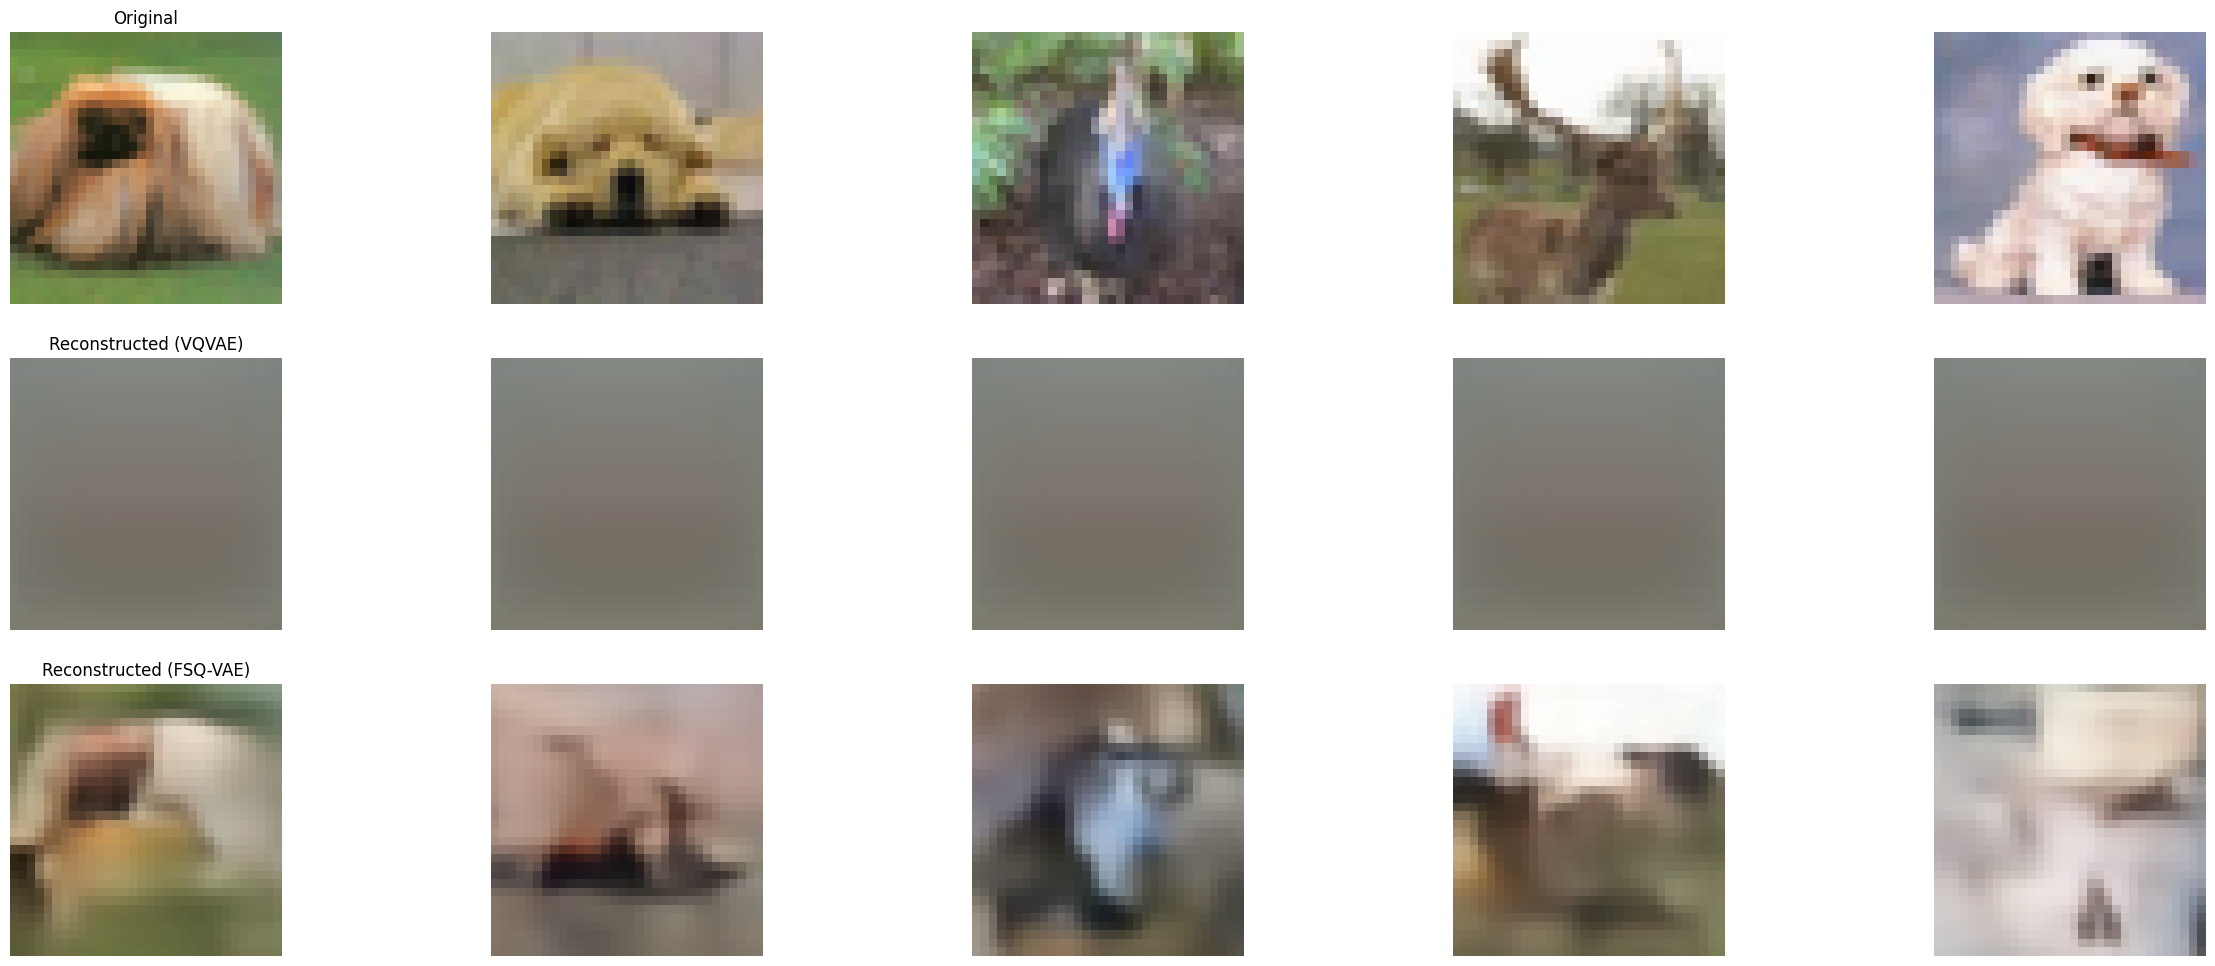

In [ ]:
# Plot some reconstructed images
import matplotlib.pyplot as plt

def plot_reconstructions(models: list[VQVAE], model_names: list[str], images: jax.Array):
    num_images = 5
    fig, axes = plt.subplots(len(models) + 1, num_images, figsize=(num_images * 2 * (len(models) + 1), 4 * (len(models) + 1)))

    # Plot original images in the first row
    for j in range(num_images):
        axes[0, j].imshow(images[j].reshape(32, 32, 3), cmap='gray')
        axes[0, j].axis('off')
        if j == 0:
            axes[0, j].set_title("Original")

    for model_idx, model in enumerate(models):
        reconstructed, _ = model(images)
        for j in range(num_images):
            # Reconstructed image
            axes[model_idx + 1, j].imshow(reconstructed[j].reshape(32, 32, 3), cmap='gray')
            axes[model_idx + 1, j].axis('off')
            if j == 0:
                axes[model_idx + 1, j].set_title(f"Reconstructed ({model_names[model_idx]})")
    plt.show()

sample_batch = next(iter(test_grain_dataset))
plot_reconstructions([vqvae, fsqvae], ["VQVAE", "FSQ-VAE"], sample_batch[:5])

In [ ]:
# Convert whole training dataset to indices and display the first image's indices
from array_record.python import array_record_module as arm
import pickle

def export_to_indices(model: VQVAE, train_data: Dataset, output_file: str, batch_size: int = 32):
    BAR_FORMAT = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"

    train_label_grain_dataset = grain.MapDataset.source(train_data) \
        .map(lambda x: {
            "img": preprocess(x["img"]),
            "label": x["label"]
        }) \
        .map(lambda x: {
            "img": x["img"],
            "img_indices": model.encode_to_indices(x["img"].reshape(1, 32, 32, 3)),
            "label": x["label"]
        }) \
        .batch(batch_size=batch_size)

    ar_writer = arm.ArrayRecordWriter(output_file, group_size=256)
    record_count = 0


    with tqdm(
        desc=f"Converting training dataset to indices ",
        total=len(train_data),
        bar_format=BAR_FORMAT,
        leave=True,
    ) as pbar:
        for record in train_label_grain_dataset:
            ar_writer.write(pickle.dumps(record))
            record_count += len(record["img"])
            pbar.update(len(record["img"]))

    ar_writer.close()


In [ ]:
export_to_indices(vqvae, train_data, './data/train_vqvae_indices.ar', batch_size=32)

Converting training dataset to indices [50000/50000] [13:41<00:00]


In [ ]:
export_to_indices(fsqvae, train_data, './data/train_fsqvae_indices.ar', batch_size=32)

Converting training dataset to indices [0/50000] [00:00<?]


ValueError: not enough values to unpack (expected 2, got 1)